# Lee Nadeau

## Assignment 4: Survey Analysis

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import pyreadstat
import os
import seaborn as sns
import collections
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import scipy.cluster.hierarchy as hier

### Clean Data

In [5]:
# Load Data
data = pd.read_excel('Survey_clean.xlsx')
data.columns = data.columns.str.strip().str.lower().str.replace(' ','').str.replace('(','').str.replace(')', '').str.replace('.', '_').str.replace('1', 'fir').str.replace('-','_')
df = data[['id_o', 'unnamed:fir', 'unnamed:2', 'q2', 'q9', 'qfir2', 'qfir4', 'qfir5', 'q30']]
df = df.rename(columns={"unnamed:fir": "Gender", "unnamed:2": "Based on the INFORMATION provided, the best strategy is to:", "q2": "Q2", "q9": "Q9", "qfir2": "Q12", "qfir4": "Q14", "qfir5": "Q15", "q30": "Q30"})
df = df.iloc[1:] # Deletes 1st column where questions were asked, causes issues with format... will bring back.

# Split id_o into 'desk' & 'trader'
df[['desk', 'trader']] = df.id_o.str.split("C", n=1, expand = True)

# Make formatting uniform
df['desk'] = df['desk'].str.replace('S 10','S10').str.replace('TralS9C','S9').str.replace('S37b08T','S3').str.replace('S3 ', 'S3')

# Ran once to move 'trader' column to start of data
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

# Ran again to move 'desk' column to start of data
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df = df.drop(columns=['id_o'])
df = df.drop(columns=['Based on the INFORMATION provided, the best strategy is to:'])

In [161]:
df.head(1)

,desk,trader,Gender,Q2,Q9,Q12,Q14,Q15,Q30
1,S6,14a1,F,1,3,2,3,2,Y


In [7]:
# Looking to see how many desks there are
df.describe(include='all') # See there are 10 desks

,desk,trader,Gender,Q2,Q9,Q12,Q14,Q15,Q30
count,363,362,363,363,363,363,363,363,363
unique,10,235,2,5,5,5,5,5,2
top,S6,10a1,M,Agree,Agree,Agree,Agree,Agree,No
freq,52,5,193,110,167,203,179,212,289


In [9]:
# Splitting desks into their own groups
s1 = df[df.desk=='S1']
s2 = df[df.desk=='S2']
s3 = df[df.desk=='S3']
s4 = df[df.desk=='S4']
s5 = df[df.desk=='S5']
s6 = df[df.desk=='S6']
s7 = df[df.desk=='S7']
s8 = df[df.desk=='S8']
s9 = df[df.desk=='S9']
s10 = df[df.desk=='S10']

# Changing responses to numerical values and 'Y/N' for Q30
df['Q2'] = df['Q2'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df['Q9'] = df['Q9'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df['Q12'] = df['Q12'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df['Q14'] = df['Q14'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df['Q15'] = df['Q15'].str.replace('Neither Agree nor Disagree', '3').str.replace('Strongly Disagree', '5').str.replace('Strongly Agree', '1').str.replace('Agree', '2').str.replace('Disagree', '4')
df['Q30'] = df['Q30'].str.replace('Yes', 'Y').str.replace('No', 'N')

In [10]:
df.head(1)

,desk,trader,Gender,Q2,Q9,Q12,Q14,Q15,Q30
1,S6,14a1,F,1,3,2,3,2,Y


### Exploring and Evaluating Data

In [21]:
# Looking at percents of traders within each desk
df['desk'].value_counts(normalize=True).sort_index()

S1     0.038567
S10    0.134986
S2     0.063361
S3     0.140496
S4     0.099174
S5     0.137741
S6     0.143251
S7     0.129477
S8     0.033058
S9     0.079890
Name: desk, dtype: float64

In [20]:
# Gives a count of traders per desk, continuation of above cell
df['desk'].value_counts()

S6     52
S3     51
S5     50
S10    49
S7     47
S4     36
S9     29
S2     23
S1     14
S8     12
Name: desk, dtype: int64

In [22]:
# Looking at male to female ratio
df['Gender'].value_counts(normalize=True).sort_index() 
# Almost evenly split, but slightly more males

F    0.46832
M    0.53168
Name: Gender, dtype: float64

#### Looking at responses

In [23]:
df['Q2'].value_counts(normalize=True).sort_index() 
# Shows that response 2 was most popular answer with 3 being close second
# These are okay, insights, but not so clear because we removed the questions from the data

1    0.110193
2    0.303030
3    0.286501
4    0.228650
5    0.071625
Name: Q2, dtype: float64

In [25]:
# Will continue with this method, but add question back in next section to make analysis mroe clear
df['Q9'].value_counts(normalize=True).sort_index()
# Response 2 was most popular answer, 3 in second

1    0.165289
2    0.460055
3    0.203857
4    0.143251
5    0.027548
Name: Q9, dtype: float64

In [26]:
df['Q12'].value_counts(normalize=True).sort_index()
# Response 2 was most popular answer, 3 in second

1    0.134986
2    0.559229
3    0.225895
4    0.066116
5    0.013774
Name: Q12, dtype: float64

In [28]:
df['Q14'].value_counts(normalize=True).sort_index()
# Response 2 was most popular answer, 3 in second

1    0.082645
2    0.493113
3    0.231405
4    0.162534
5    0.030303
Name: Q14, dtype: float64

In [30]:
df['Q15'].value_counts(normalize=True).sort_index()
# Response 2 was most popular answer, 1 in second **

1    0.234160
2    0.584022
3    0.134986
4    0.035813
5    0.011019
Name: Q15, dtype: float64

In [31]:
df['Q30'].value_counts(normalize=True).sort_index()
# Almost 80% answered 'No'

N    0.796143
Y    0.203857
Name: Q30, dtype: float64

In [34]:
df['Q30'].value_counts()

N    289
Y     74
Name: Q30, dtype: int64

### * From this we can see that response 2 was the most popular response among most of the questions.
### * Response 3 was the second most popular response in all of the questions besides 15, where 1 was the second most popular response.
### * No was the popular response in question 30.

***

## Using 'pyreadstat' analyze with question data
### Data was edited in SPSS to add variables to the data

In [36]:
# .SAV file loaded in
df_sav, meta = pyreadstat.read_sav('data_frame.sav')

In [39]:
df_sav.head(3)

,desk,trader,Gender,Q2,Q9,Q12,Q14,Q15,Q30
0,S6,14a1,F,1.0,3.0,2.0,3.0,2.0,Y
1,S6,12B1,F,5.0,1.0,3.0,4.0,1.0,N
2,S6,1514,M,1.0,4.0,3.0,3.0,1.0,N


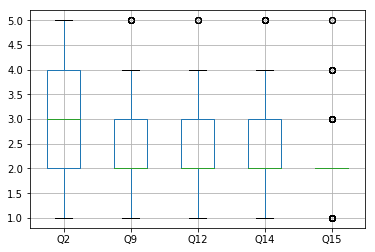

In [185]:
df_sav.boxplot()

In [50]:
meta.column_labels
# Can see questions are now part of the data again

[None,
 None,
 None,
 'I traded using ALL of the information provided to me at each stage',
 'I believe that I can improve on my net profits if I had more information even if I did not have any technological tools to analyze the information',
 'The source (Highly reputed like Wall Street Journal/ Bloomberg versus low/unknown reputation like Sun news) of information would impact my trading decisions',
 'The medium (news /blog /video/ tool based) of information impacted my trading decisions',
 'I believe that more stock specific information could have helped me to increase my net profits',
 'I have had prior experience in live trading stock /shares']

In [51]:
meta_dict = dict(zip(meta.column_names, meta.column_labels))

In [52]:
# Displays the question tied to 'Q2' - Will be used below.
meta_dict['Q2']

'I traded using ALL of the information provided to me at each stage'

In [56]:
# This gives us a similar result to what was analyzed above.
df_sav['Q2'].value_counts(normalize=True).sort_index()

1.0    0.110193
2.0    0.303030
3.0    0.286501
4.0    0.228650
5.0    0.071625
Name: Q2, dtype: float64

In [57]:
# The responses are added into the analysis for easy interpretation.
Q2_sav = df_sav['Q2'].map(meta.variable_value_labels['Q2']).value_counts(normalize=True)
Q9_sav = df_sav['Q9'].map(meta.variable_value_labels['Q9']).value_counts(normalize=True)
Q12_sav = df_sav['Q12'].map(meta.variable_value_labels['Q12']).value_counts(normalize=True)
Q14_sav = df_sav['Q14'].map(meta.variable_value_labels['Q14']).value_counts(normalize=True)
Q15_sav = df_sav['Q15'].map(meta.variable_value_labels['Q15']).value_counts(normalize=True)
Q30_sav = df_sav['Q30'].map(meta.variable_value_labels['Q30']).value_counts(normalize=True)

In [65]:
meta_dict['Q2']

'I traded using ALL of the information provided to me at each stage'

In [64]:
Q2_sav
# Although Agree is the most popular response, NAnD and Disagress are close in %
# Therefore its split that about 1/3 used ALL info provided, and <1/3 was in the middle and 1/5 did not.

Agree                         0.303030
Neither Agree nor Disagree    0.286501
Disagree                      0.228650
Strongly Agree                0.110193
Strongly Disagree             0.071625
Name: Q2, dtype: float64

In [66]:
meta_dict['Q9']

'I believe that I can improve on my net profits if I had more information even if I did not have any technological tools to analyze the information'

In [59]:
Q9_sav
# Almost half of the respondents believed that if they had more info they would have improved their net profits.

Agree                         0.460055
Neither Agree nor Disagree    0.203857
Strongly Agree                0.165289
Disagree                      0.143251
Strongly Disagree             0.027548
Name: Q9, dtype: float64

In [67]:
meta_dict['Q12']

'The source (Highly reputed like Wall Street Journal/ Bloomberg versus low/unknown reputation like Sun news) of information would impact my trading decisions'

In [61]:
Q12_sav
# A little more than half agreed that highly reputable sources > low rep sources impacted their trading decisions

Agree                         0.559229
Neither Agree nor Disagree    0.225895
Strongly Agree                0.134986
Disagree                      0.066116
Strongly Disagree             0.013774
Name: Q12, dtype: float64

In [68]:
meta_dict['Q14']

'The medium (news /blog /video/ tool based) of information impacted my trading decisions'

In [62]:
Q14_sav 
# Almost half agreed that (news /blog /video/ tool based) information impacted their trading decisions

Agree                         0.493113
Neither Agree nor Disagree    0.231405
Disagree                      0.162534
Strongly Agree                0.082645
Strongly Disagree             0.030303
Name: Q14, dtype: float64

In [69]:
meta_dict['Q15']

'I believe that more stock specific information could have helped me to increase my net profits'

In [63]:
Q15_sav
# Combining 'Strongly Agree' & 'Agree', >80% of responders said more stock spec. info would have helped their net profits.

Agree                         0.584022
Strongly Agree                0.234160
Neither Agree nor Disagree    0.134986
Disagree                      0.035813
Strongly Disagree             0.011019
Name: Q15, dtype: float64

### Can conclude from this that 'Agree' was the most popular responses to each quesiton.

In [70]:
meta_dict['Q30']

'I have had prior experience in live trading stock /shares'

In [71]:
Q30_sav

No     0.796143
Yes    0.203857
Name: Q30, dtype: float64

### The majority (80%) of the participants did not have any prior experience trading stocks live.

***

## This next section looks at the responses of each trade desk using crosstabs

In [72]:
# Set up desks to cross tab each question
Q2_desks = pd.crosstab(df_sav['Q2'].\
        map(meta.variable_value_labels['Q2']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q2'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

Q9_desks = pd.crosstab(df_sav['Q9'].\
        map(meta.variable_value_labels['Q9']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q9'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

Q12_desks = pd.crosstab(df_sav['Q12'].\
        map(meta.variable_value_labels['Q12']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q12'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

Q14_desks = pd.crosstab(df_sav['Q14'].\
        map(meta.variable_value_labels['Q14']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q14'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

Q15_desks = pd.crosstab(df_sav['Q15'].\
        map(meta.variable_value_labels['Q15']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q15'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

Q30_desks = pd.crosstab(df_sav['Q30'].\
        map(meta.variable_value_labels['Q30']), \
        df_sav['desk'].map(meta.variable_value_labels['desk']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q30'].values()]. \
        loc[:,meta.variable_value_labels['desk'].values()]*100

In [132]:
meta_dict['Q2']

'I traded using ALL of the information provided to me at each stage'

In [73]:
Q2_desks

# Most popular response from each desk:
# S1: Disagree
# S2: Agree/NAnD
# S3: Agree
# S4: Agree
# S5: Agree
# S6: Agree/NAnD
# S7: NAnD
# S8: Agree
# S9: NAnD
# S10: Agree/Disagree

# Desk 1 did not use ALL of the info provided in each stage.
# Desk 2 & 6 had a splot Agree/NAnD
# Desk 7 & 9 were NAnD
# Desk 10 had a split Agree and Disagree

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q2,,,,,,,,,,
Strongly Agree,7.142857,8.695652,7.843137,2.777778,16.0,19.230769,8.510638,8.333333,3.448276,16.326531
Agree,14.285714,30.434783,39.215686,33.333333,34.0,28.846154,25.531915,33.333333,24.137931,28.571429
Neither Agree nor Disagree,28.571429,30.434783,27.450980,36.111111,16.0,28.846154,34.042553,16.666667,44.827586,24.489796
Disagree,42.857143,26.086957,19.607843,25.000000,28.0,5.769231,25.531915,16.666667,24.137931,28.571429
Strongly Disagree,7.142857,4.347826,5.882353,2.777778,6.0,17.307692,6.382979,25.000000,3.448276,2.040816


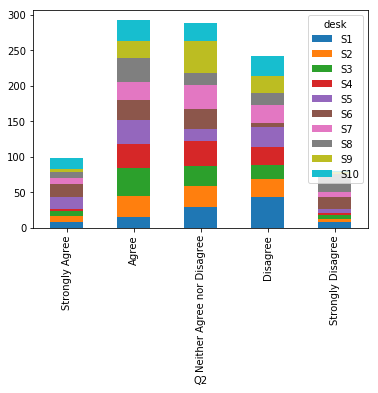

In [113]:
Q2_desks.plot(kind='bar', stacked=True, grid=False)

# Can see some of the split responses around Agree/NAnD/Disagree

In [134]:
meta_dict['Q9']

'I believe that I can improve on my net profits if I had more information even if I did not have any technological tools to analyze the information'

In [128]:
Q9_desks

# Most popular response from each desk:
# S1: Agree
# S2: Agree
# S3: Agree
# S4: Agree
# S5: Agree
# S6: Strongly Agree
# S7: Agree
# S8: Agree
# S9: Agree
# S10: Agree

# All agree that they would have performed better if provided more info.

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q9,,,,,,,,,,
Strongly Agree,7.142857,8.695652,19.607843,8.333333,16.0,30.769231,14.893617,16.666667,13.793103,14.285714
Agree,50.000000,52.173913,50.980392,47.222222,42.0,25.000000,57.446809,50.000000,58.620690,42.857143
Neither Agree nor Disagree,35.714286,26.086957,7.843137,27.777778,20.0,26.923077,14.893617,16.666667,17.241379,22.448980
Disagree,7.142857,13.043478,17.647059,11.111111,20.0,13.461538,10.638298,16.666667,6.896552,18.367347
Strongly Disagree,0.000000,0.000000,3.921569,5.555556,2.0,3.846154,2.127660,0.000000,3.448276,2.040816


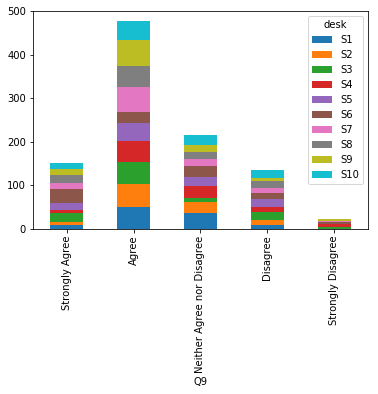

In [135]:
Q9_desks.plot(kind='bar', stacked=True, grid=False)

# Agree prevails

In [136]:
meta_dict['Q12']

'The source (Highly reputed like Wall Street Journal/ Bloomberg versus low/unknown reputation like Sun news) of information would impact my trading decisions'

In [129]:
Q12_desks

# Most popular response from each desk:
# S1: Agree
# S2: Agree
# S3: Agree
# S4: Agree
# S5: Agree
# S6: Agree
# S7: Agree
# S8: Agree
# S9: NAnD
# S10: Agree

# 90% (-desk 9), agree that high rep > low rep news sources impacted trade decisions

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q12,,,,,,,,,,
Strongly Agree,21.428571,13.043478,19.607843,27.777778,8.0,9.615385,8.510638,8.333333,10.344828,12.244898
Agree,50.000000,73.913043,60.784314,44.444444,72.0,59.615385,42.553191,50.000000,31.034483,61.224490
Neither Agree nor Disagree,21.428571,13.043478,17.647059,13.888889,18.0,19.230769,34.042553,33.333333,44.827586,20.408163
Disagree,7.142857,0.000000,1.960784,13.888889,0.0,7.692308,12.765957,8.333333,13.793103,4.081633
Strongly Disagree,0.000000,0.000000,0.000000,0.000000,2.0,3.846154,2.127660,0.000000,0.000000,2.040816


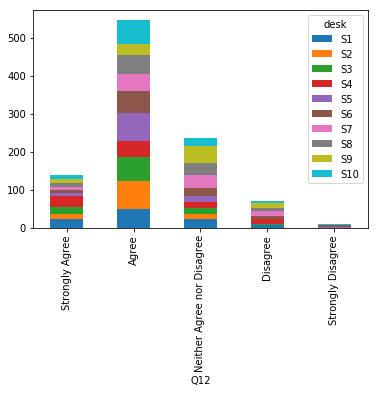

In [137]:
Q12_desks.plot(kind='bar', stacked=True, grid=False)

# Agree prevails

In [138]:
meta_dict['Q14']

'The medium (news /blog /video/ tool based) of information impacted my trading decisions'

In [130]:
Q14_desks

# Most popular response from each desk:
# S1: Agree
# S2: Agree
# S3: Agree
# S4: Agree
# S5: Agree
# S6: Agree
# S7: Agree
# S8: Agree/Disagree
# S9: Disagree
# S10: Agree

# News, etc impacted the trade decisions of all desks minus (split of 8), and 9.

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q14,,,,,,,,,,
Strongly Agree,14.285714,4.347826,9.803922,13.888889,4.0,5.769231,6.382979,8.333333,6.896552,12.244898
Agree,57.142857,60.869565,74.509804,61.111111,50.0,32.692308,36.170213,33.333333,31.034483,51.020408
Neither Agree nor Disagree,14.285714,21.739130,11.764706,22.222222,24.0,26.923077,29.787234,16.666667,24.137931,28.571429
Disagree,14.285714,13.043478,3.921569,2.777778,20.0,25.000000,21.276596,33.333333,34.482759,8.163265
Strongly Disagree,0.000000,0.000000,0.000000,0.000000,2.0,9.615385,6.382979,8.333333,3.448276,0.000000


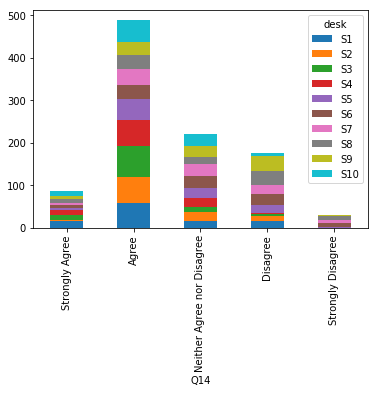

In [139]:
Q14_desks.plot(kind='bar', stacked=True, grid=False)

# Agree prevails

In [140]:
meta_dict['Q15']

'I believe that more stock specific information could have helped me to increase my net profits'

In [131]:
Q15_desks

# Most popular response from each desk:
# S1: Agree
# S2: Agree
# S3: Agree
# S4: Agree
# S5: Agree
# S6: Agree
# S7: Agree
# S8: Agree
# S9: Agree
# S10: Agree

# All agree that more specific stock info would have helped net profits.

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q15,,,,,,,,,,
Strongly Agree,21.428571,13.043478,31.372549,30.555556,12.0,30.769231,17.021277,16.666667,13.793103,32.653061
Agree,57.142857,73.913043,56.862745,52.777778,70.0,48.076923,57.446809,50.000000,65.517241,55.102041
Neither Agree nor Disagree,7.142857,8.695652,9.803922,11.111111,14.0,15.384615,19.148936,25.000000,20.689655,8.163265
Disagree,14.285714,4.347826,0.000000,5.555556,4.0,1.923077,4.255319,8.333333,0.000000,4.081633
Strongly Disagree,0.000000,0.000000,1.960784,0.000000,0.0,3.846154,2.127660,0.000000,0.000000,0.000000


In [141]:
meta_dict['Q30']

'I have had prior experience in live trading stock /shares'

In [126]:
Q30_desks

# Most popular response from each desk:
# S1: No
# S2: No
# S3: No
# S4: No
# S5: No
# S6: No
# S7: No
# S8: No
# S9: No
# S10: No

# Desk 1 was closest to a 50/50 split, so they had the most experienced traders.
# Desks 2, 3, 6, 7, 8, and 10 all had around 1/5 of their traders having had experience.

desk,S1,S2,S3,S4,S5,S6,S7,S8,S9,S10
Q30,,,,,,,,,,
No,57.142857,78.26087,76.470588,86.111111,84.0,78.846154,78.723404,75.0,89.655172,77.55102
Yes,42.857143,21.73913,23.529412,13.888889,16.0,21.153846,21.276596,25.0,10.344828,22.44898


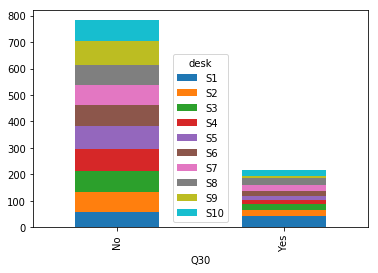

In [142]:
Q30_desks.plot(kind='bar', stacked=True, grid=False)

## Could even go as far as to look at gender specific responses

In [151]:
# Looking at Gender responses:
Q2_gender = pd.crosstab(df_sav['Q2'].\
        map(meta.variable_value_labels['Q2']), \
        df_sav['Gender'].map(meta.variable_value_labels['Gender']), \
        dropna=True, normalize='columns'). \
        loc[meta.variable_value_labels['Q2'].values()]. \
        loc[:,meta.variable_value_labels['Gender'].values()]*100

Q2_gender

# Females Agreed
# Males NAnD

Gender,F,M
Q2,,
Strongly Agree,12.941176,9.326425
Agree,32.352941,28.497409
Neither Agree nor Disagree,22.941176,33.678756
Disagree,21.764706,23.834197
Strongly Disagree,10.000000,4.663212


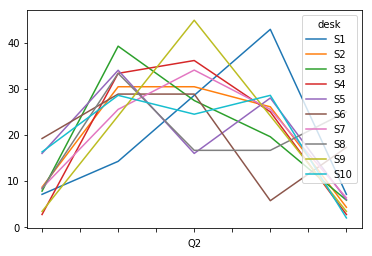

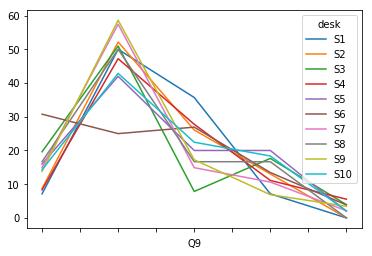

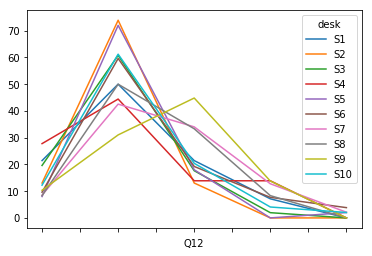

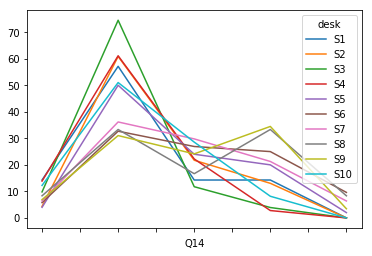

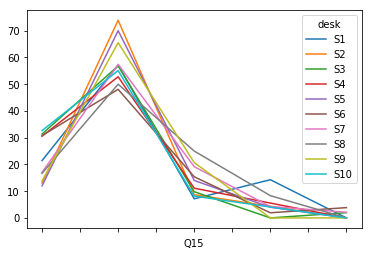

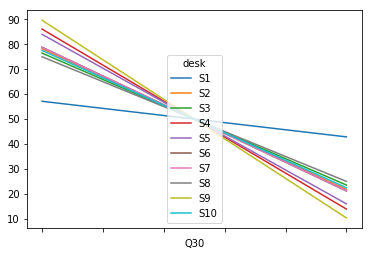

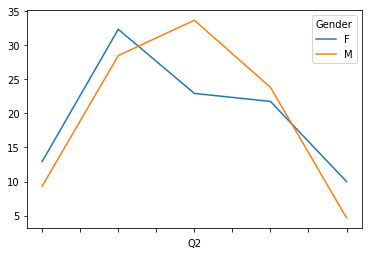

In [152]:
## Seeing what some plots might look like:
Q2_desks.plot() # Can see how there are more mixed responses
Q9_desks.plot() # More responses around Agree
Q12_desks.plot() # More responses around Agree
Q14_desks.plot() # More responses around Agree
Q15_desks.plot() # More responses around Agree 
Q30_desks.plot() # Responses around No

Q2_gender.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a269b5978>,
      dtype=object)

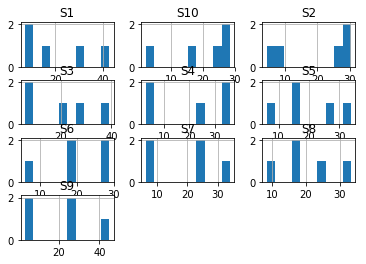

In [154]:
Q2_desks.hist() # Interesting to look at, but hard to find insights

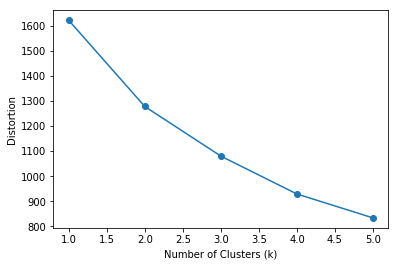

In [167]:
questions = df.iloc[:,3:8]

# Using a basic KMeans algorithm to look at the questions only
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, max_iter=500)
# Attempt 1: Given all the data
kmeans.fit(questions)

distortions = []
K_to_try = range(1, 6)

for i in K_to_try:
    model = KMeans(
            n_clusters=i,
            init='k-means++',
            n_jobs=-1,
            random_state=1)
    model.fit(questions)
    distortions.append(model.inertia_)
plt.plot(K_to_try, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [165]:
# Using the best K from elbow method
model = KMeans(
    n_clusters=3,
    init='k-means++',
    n_jobs=-1,
    random_state=1)

model = model.fit(questions)

y = model.predict(questions)
y

array([1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2,
       1, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 1, 0,
       2, 2, 0, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0,
       2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 1, 2, 1, 0, 2, 0, 2, 0, 1, 1, 2, 1,
       0, 0, 0, 1, 1, 2, 0, 2, 2, 1, 2, 2, 1, 0, 1, 1, 2, 2, 1, 2, 1, 2,
       2, 0, 0, 1, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0,
       0, 2, 2, 1, 2, 1, 0, 0, 1, 0, 2, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2,
       2, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 1, 2, 0, 1, 2, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 2, 1, 0,
       1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0,
       0, 2, 0, 1, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 1,
       1, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,

In [173]:
pca = PCA(n_components = 2, random_state=1)
X_pca = pca.fit_transform(questions)

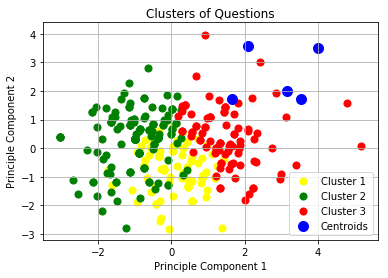

In [175]:
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], s = 50, c = 'yellow', label = 'Cluster 1')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], s = 50, c = 'red', label = 'Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('Clusters of Questions')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid()
plt.show()

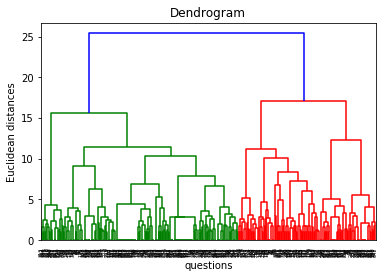

In [177]:
dendrogram = hier.dendrogram(hier.linkage(questions, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Questions')
plt.ylabel('Euclidean distances')
plt.show() # Could not get size of plot to change

In [186]:
s2[["trader"]]

,trader
211,108T
216,1008
222,1208
223,1208
224,1008
225,108T
227,1108
228,208T
229,608T
230,308T
